# 1 Dimensional Convolution (Conv1D) for Regression: Predict house prices 

[In a previous tutorial](https://youtu.be/WZdxt9xatrY), we focus on  **1 Dimensional Convolution (Conv1D)** and discuss how it works in a simple example. ***As I received several questions*** about how to apply 1 Dimensional Convolution onto a regression problem, I develop this notebook. If you need to **refresh your information** about 1 Dimensional Convolution, please **watch** the previous tutorial [on my Youtube channel](https://youtu.be/WZdxt9xatrY)

Thus, today, we will use **Keras Conv1d** layer for a regression problem. 
As you might know, **Boston House Prices** data set is a well known data set. Below, we will **first** train a **Multi-Layer Perceptron (MLP) model** to predict house prices. Then, we will develop a model using **Keras Conv1D** layer. To train and test the Conv1D model, we will **reshape the train and test data** such that Conv1D can work on them.

If you are interested in **Deep Neural Networks** and want to **learn them by coding**, please **subcribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new content is uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing) given in the video descriptions below.

If you are ready, let's get started!




##You can watch this notebook:

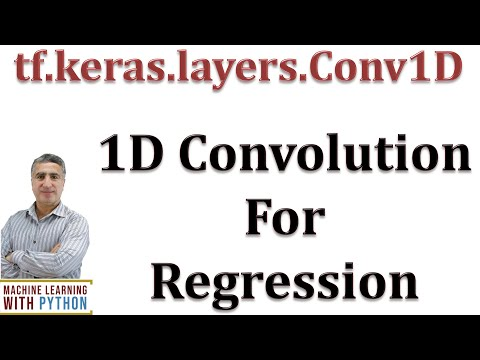

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('JzoIHdkFcQU', width=800, height=450) 

https://youtu.be/JzoIHdkFcQU



# Include Libraries and Auxiliary Functions

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.3.0


In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
  plt.legend()
  plt.ylim([0,max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [1000$]')
  plt.ylabel('Predictions [1000$]')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100],[-100,100])

  plt.figure()
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error [1000$]")
  _ = plt.ylabel("Count")

# Notice
***As a base model***, I will use the **TensorFlow official example** for ***MLP model*** and compare its performance with **my Conv1D model**. Thus, we will be able to observe the relative success of **Conv1D model** with respect to **a professional sample model**.

You can access the original notebook ["Predict house prices: regression" with Multi-layer Perceptron here.](https://colab.research.google.com/github/MarkDaoust/models/blob/add-regression-plots/samples/core/tutorials/keras/basic_regression.ipynb) 

If you run this notebook,  you would generate mean absolute error values different than the reported ones here due to stochastic nature of ANNs.  

# What is regression? 

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange). 

This notebook builds two different models to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, I'll provide the models with some data points about the suburb, such as the crime rate and the local property tax rate.


## The Boston Housing Prices dataset

This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in TensorFlow. Download and shuffle the training set:

In [ ]:
boston_housing = tf.keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

### Examples and features 

This dataset has 506 total examples which are split between **404** training examples and **102** test examples:

In [ ]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per $10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.


In [ ]:
print(train_data[0])  # Display sample features, notice the different scales

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:

In [ ]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

CRIM    ZN  INDUS  CHAS    NOX  ...   RAD    TAX  PTRATIO       B  LSTAT
0  1.23247   0.0   8.14   0.0  0.538  ...   4.0  307.0     21.0  396.90  18.72
1  0.02177  82.5   2.03   0.0  0.415  ...   2.0  348.0     14.7  395.38   3.11
2  4.89822   0.0  18.10   0.0  0.631  ...  24.0  666.0     20.2  375.52   3.26
3  0.03961   0.0   5.19   0.0  0.515  ...   5.0  224.0     20.2  396.90   8.01
4  3.69311   0.0  18.10   0.0  0.713  ...  24.0  666.0     20.2  391.43  14.65

[5 rows x 13 columns]

### Labels

The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [ ]:
print(train_labels[0:10])  # Display first 10 entries

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


## Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [ ]:
# Test data is *not* used when calculating the mean and std.
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependant on the choice of units used in the input.

## Create the MLP model

Let's build an MLP model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(train_data.shape[1],)),                  
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ], name="MLP_model")

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "MLP_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
EPOCHS = 500
# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Epoch 1/500
11/11 [==============================] - 0s 12ms/step - loss: 543.1906 - mae: 21.3777 - val_loss: 566.2466 - val_mae: 21.9570
Epoch 2/500
11/11 [==============================] - 0s 5ms/step - loss: 467.3811 - mae: 19.5663 - val_loss: 484.0857 - val_mae: 20.0287
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 386.2641 - mae: 17.4566 - val_loss: 391.4663 - val_mae: 17.6781
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 299.5808 - mae: 14.9836 - val_loss: 300.2606 - val_mae: 15.0185
Epoch 5/500
11/11 [==============================] - 0s 4ms/step - loss: 217.6953 - mae: 12.3381 - val_loss: 214.4957 - val_mae: 12.0737
Epoch 6/500
11/11 [==============================] - 0s 4ms/step - loss: 147.3429 - mae: 9.6540 - val_loss: 148.6694 - val_mae: 9.3483
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 97.5165 - mae: 7.4497 - val_loss: 99.5994 - val_mae: 7.4300
Epoch 8/500
11/11 [===========================

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

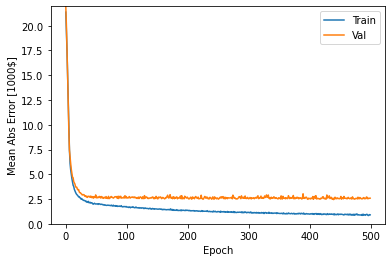

In [ ]:
plot_history(history)

The graph shows the average error **in Validation set** is about $2,600 dollars. Is this good? 

Well, \$2,600 is not an insignificant amount when some of the labels are only $15,000.

Let's see how did the model performs on the **Test set**:

In [ ]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2872.95


## Predict

Finally, predict some housing prices using data in the testing set:

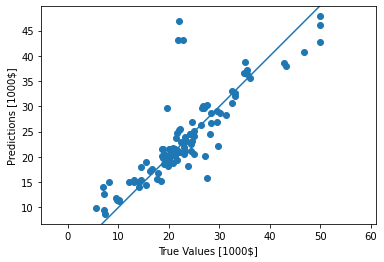

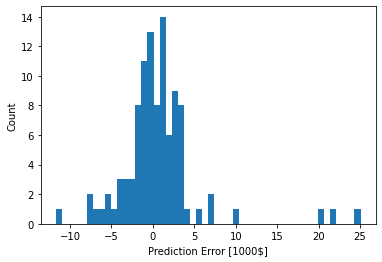

In [ ]:
test_predictions = model.predict(test_data).flatten()
plot_prediction(test_labels, test_predictions)

## Observations

So far, we implemented a MLP model to handle the "**Boston House Prices**" regression problem.

Mean Absolute Error in Validation is around **\$2,600** whereas in Testing, it is about **$2900**

## Create the Conv1D model

Let's build an Conv1D model. Here, we'll use a `Sequential` model with 3 Conv1D layers, one MaxPooling1D layer, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model` as we did above.

## Reshape Data sets
As you might remember, Conv1D layer expects input shape in 3D as

  `[batch_size, time_steps, input_dimension]`

However, current data is in the shape of

`[batch_size, features]`

See below:

In [ ]:
print(train_data.shape)
print(train_data[0].shape)
print(train_data[0])

(404, 13)
(13,)
[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


That is, in the current data set each sample has 13 features and no timesteps!

**Basically, we convert features to timesteps**

To convert 2D of input data into a 3D input, we simply **reshape** as follows:

In [ ]:
sample_size = train_data.shape[0] # number of samples in train set
time_steps  = train_data.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = train_data.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (404, 13, 1)
1 Sample shape:
 (13, 1)
An example sample:
 [[-0.27224633]
 [-0.48361547]
 [-0.43576161]
 [-0.25683275]
 [-0.1652266 ]
 [-0.1764426 ]
 [ 0.81306188]
 [ 0.1166983 ]
 [-0.62624905]
 [-0.59517003]
 [ 1.14850044]
 [ 0.44807713]
 [ 0.8252202 ]]


After conversion, we have a train data set whose shape is

  `[batch_size, time_steps, input_dimension]` ---> `[404, 13, 1]`

That is, each sample has **13 time steps with 1 input dimension**. You can also think as `each sample has 13 rows 1 column`!



##Reminder
* `Conv1D(filters=1, kernel_size=7, activation='relu')` 

<img src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/conv1d.gif?raw=true" width="500">

We need to **reshape** the Test data as well:

In [ ]:
test_data_reshaped = test_data.reshape(test_data.shape[0],test_data.shape[1],1)

Now, we can create Conv1D model as below.

In [ ]:
def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #13
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(keras.layers.Dense(n_features, name="Dense_2"))


  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
  return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 7, 64)             512       
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 5, 32)             6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 4, 16)             1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 2, 16)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 32)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Store training stats
history = model_conv1D.fit(train_data_reshaped, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Epoch 1/500
11/11 [==============================] - 0s 15ms/step - loss: 533.2971 - mae: 21.2021 - val_loss: 519.1226 - val_mae: 20.8930
Epoch 2/500
11/11 [==============================] - 0s 4ms/step - loss: 336.0115 - mae: 15.9971 - val_loss: 218.5526 - val_mae: 12.3240
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 121.2078 - mae: 8.7730 - val_loss: 105.7616 - val_mae: 7.6652
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 80.5962 - mae: 6.8488 - val_loss: 78.4770 - val_mae: 6.4787
Epoch 5/500
11/11 [==============================] - 0s 5ms/step - loss: 67.4674 - mae: 6.1211 - val_loss: 71.0500 - val_mae: 6.1121
Epoch 6/500
11/11 [==============================] - 0s 5ms/step - loss: 64.5087 - mae: 5.8620 - val_loss: 70.0177 - val_mae: 6.2327
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 61.8386 - mae: 5.7873 - val_loss: 60.7205 - val_mae: 5.5974
Epoch 8/500
11/11 [==============================] - 0s 4m

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

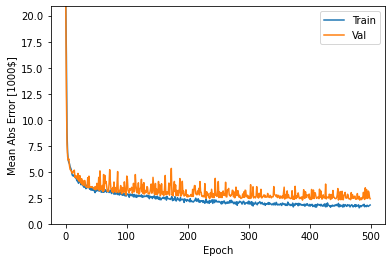

In [ ]:
plot_history(history)

The graph shows the average error **in Validation set** is about $2,400 dollars. Is this good? 

Well, \$2,400 is not an insignificant amount when some of the labels are only $15,000.

Let's see how did the model performs on the **Test set**:

In [ ]:
[loss, mae] = model_conv1D.evaluate(test_data_reshaped, test_labels, verbose=0)
print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2684.52


## Predict

Finally, predict some housing prices using data in the testing set:

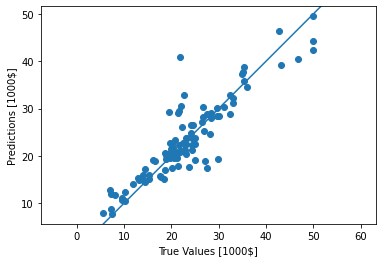

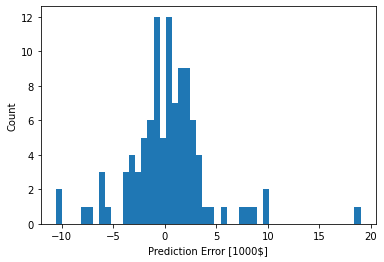

In [ ]:
test_predictions = model_conv1D.predict(test_data_reshaped).flatten()
plot_prediction(test_labels, test_predictions)

## Observations

So far, we implemented an ***MLP model*** and a ***Conv1D model*** to handle the "**Boston House Prices**" regression problem.

MLP model generates Mean Absolute Error:
* in Validation is around **\$2,600** whereas in Testing, it is about **$2900**

Conv1D model generates Mean Absolute Error:
* in Validation is around **\$2,400** whereas in Testing, it is about **$2,700**

Thus, **Conv1D** model is a **competitive** approach considering **MLP** model in the regression problem at hand. 

To use a Conv1D model, you need to **reshape** the input as 

`[batch_size, time_steps, input_dimension]`

**I hope this tutorial helps you to use Conv1D layer successfuly!**


